# Comparison with two-marginal solver

In [40]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 

from scipy.ndimage import gaussian_filter

In [41]:

def plot_measures(measures, filename=None):

    fig, ax = plt.subplots(1, len(measures), figsize=(12,6),sharey=True)
    for i in range(len(measures)):
        ax[i].imshow(measures[i], origin='lower', extent=(0,1,0,1), cmap='Greys')
        ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i),fontsize=18)
        ax[i].set_xlabel('$x_1$',fontsize=18)
        ax[i].set_xticks([0,1])
        ax[i].set_yticks([0,1])

        ax[i].tick_params(axis='x',labelsize=14)
        ax[i].tick_params(axis='y',labelsize=14)

    ax[0].set_ylabel('$x_2$',fontsize=18)
    plt.subplots_adjust(wspace=0.08)

    if(filename is not None):
        plt.savefig(filename,bbox_inches='tight')
    plt.show()

## Simple circles

In [42]:
# Grid of size n1 x n2
n1 = 512   # x axis
n2 = 512   # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

r = 0.125

positions = np.array([[0.2,0.8],
                      [0.4,0.6],
                      [0.6,0.4],
                      [0.8,0.2]])

# measures = [None]*len(positions)
measures = [None]*(len(positions))

for i in range(len(positions)):
    xc,yc = positions[i]
    measures[i] = np.zeros((n2, n1))
    measures[i][(x-xc)**2 + (y-yc)**2 < r**2] = 1

    # Normalize
    measures[i] *= n1*n2 / np.sum(measures[i])

    measures[i] = np.flipud(measures[i])


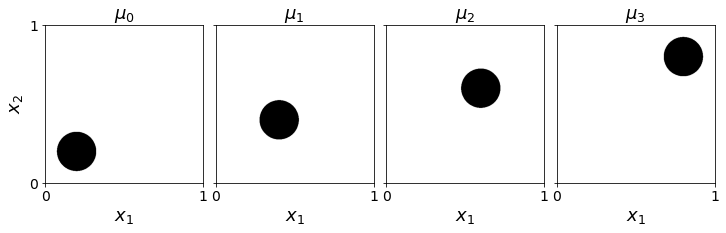

In [43]:
plot_measures(measures)

In [44]:
unroll_node = 0

edge_list = [[0,1],
             [0,2],
             [2,3]]
             
prob = MMOTSolver(measures, edge_list, x, y, unroll_node)


res = prob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-12, gtol_abs=1e-8)

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   1.0000,  9.3417e-02,   1.6486e+00,         0
       10,   0.0111,  2.3958e-01,   1.2637e-02,         0
       20,   0.0267,  2.4002e-01,   5.5909e-04,         0
       30,   0.1284,  2.4005e-01,   5.8244e-05,         0
       40,   0.0257,  2.4006e-01,   5.9143e-05,         2
       50,   0.0549,  2.4006e-01,   5.6647e-06,         0
       60,   0.0196,  2.4006e-01,   1.2893e-06,         0
       70,   0.0139,  2.4006e-01,   3.4035e-06,         0
       80,   0.0099,  2.4006e-01,   1.1036e-06,         0
       90,   0.0071,  2.4006e-01,   3.0247e-06,         0
      100,   0.0050,  2.4006e-01,   1.0059e-06,         0
      110,   0.0036,  2.4006e-01,   2.7766e-06,         0
      120,   0.0025,  2.4006e-01,   9.7856e-07,         0
      130,   0.0054,  2.4006e-01,   2.6620e-06,         0
      140,   0.0039,  2.4006e-01,   9.7680e-07,         0
      150,   0.0028,  2.4006e-01,   2.5519e-06,         0
      160,   0

In [45]:
bfm_res = [None]*(len(measures)-1)
for i in range(len(measures)-1):
    prob = MMOTSolver(measures[i:i+2], [[0,1]], x, y, 0)
    bfm_res[i] = prob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-12, gtol_abs=1e-8)


print('MMOT Cost: ', np.sum([r.costs[-1] for r in bfm_res]), ' vs ', res.costs[-1])

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  3.2476e-02,   3.4092e-01,         2
       10,   0.0111,  4.0024e-02,   4.0951e-06,         2
       20,   0.0000,  4.0024e-02,   4.2492e-06,         3
       22,   0.0000,  4.0024e-02,   4.2493e-06,         3
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  3.2286e-02,   3.0504e-01,         2
       10,   0.0667,  3.9982e-02,   1.3715e-05,         0
       20,   0.0000,  3.9983e-02,   9.0152e-06,         4
       20,   0.0000,  3.9983e-02,   9.0152e-06,         4
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  3.2826e-02,   3.2791e-01,         2
       10,   0.0167,  4.0024e-02,   6.7798e-06,         0
       20,   0.0007,  4.0024e-02,   5.1981e-06,         5
       24,   0.0000,  4.0024e-02,   5.2415e-06,         4
Terminating due to small change in obj

## More Complicated Marginals

In [46]:
def sharpen(img):
    blurred = gaussian_filter(img, sigma=7)
    
    blurred[blurred<0.5*np.max(blurred)] = 0.0
    blurred[blurred>0] = 1.0

    blurred /= np.sum(blurred)
    return blurred

def pad(img,pad_size=4):
    temp = np.ones((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
    temp[pad_size:-pad_size,pad_size:-pad_size] = img
    return temp

def rescale(img):
    output = np.zeros((2*img.shape[0],2*img.shape[1]))
    output[0::2,0::2] = img 
    output[1::2,0::2] = img 
    output[1::2,1::2] = img 
    output[0::2,1::2] = img 

    return output


In [47]:
measures = [None]*4
measures[0] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/redcross.png')[:, :, 2])))))
measures[1] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/tooth.png')[:, :, 2])))))
measures[2] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/heart.png')[:, :, 2])))))
measures[3] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/duck.png')[:, :, 2])))))

for i in range(len(measures)):
    measures[i] *= np.prod(measures[i].shape)/np.sum(measures[i])
   
print('Marginal size = ', measures[0].shape)

# Grid of size n1 x n2
n1,n2 = measures[0].shape

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

Marginal size =  (1088, 1088)


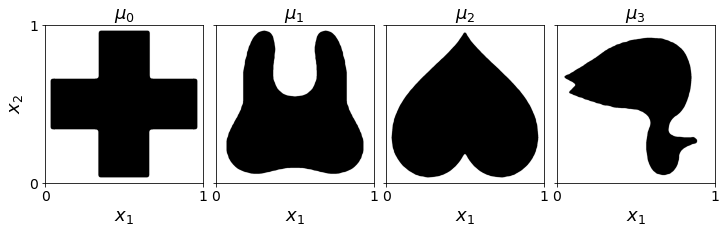

In [48]:
plot_measures(measures)

In [49]:
prob = MMOTSolver(measures, edge_list, x, y, unroll_node)


res = prob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-12, gtol_abs=1e-6)

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   1.0000,  8.5021e-03,   9.3736e-02,         0
       10,   0.1250,  3.5732e-02,   2.0738e-03,         3
       20,   0.3003,  3.6298e-02,   1.0495e-04,         0
       30,   0.7119,  3.6372e-02,   2.8188e-05,         0
       40,   0.0625,  3.6388e-02,   3.4803e-05,         4
       50,   0.1406,  3.6395e-02,   5.4176e-06,         0
       60,   0.3379,  3.6398e-02,   2.3204e-06,         0
       70,   0.7119,  3.6401e-02,   1.5874e-06,         0
       80,   0.0713,  3.6401e-02,   9.7082e-07,         0
       80,   0.0713,  3.6401e-02,   9.7082e-07,         0
Terminating due to small gradient norm.


### Two-Marginal Solve

In [50]:

bfm_res = [None]*(len(measures)-1)
for i in range(len(measures)-1):
    prob = MMOTSolver(measures[i:i+2], [[0,1]], x, y, 0)
    bfm_res[i] = prob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-12, gtol_abs=1e-8)



Iteration, StepSize,        Cost,        Error,  Line Its
        0,   1.0000,  3.9277e-03,   1.7696e-02,         0
       10,   0.5625,  6.9856e-03,   5.5898e-05,         0
       20,   1.0000,  6.9891e-03,   3.3346e-07,         0
       30,   1.0000,  6.9895e-03,   1.7784e-07,         0
       40,   0.3560,  6.9897e-03,   1.4233e-07,         1
       50,   0.0422,  6.9897e-03,   1.4873e-07,         1
       60,   0.0100,  6.9897e-03,   1.4910e-07,         1
       70,   0.0024,  6.9897e-03,   1.4902e-07,         1
       80,   0.0006,  6.9897e-03,   1.4900e-07,         1
       90,   0.0001,  6.9897e-03,   1.4900e-07,         1
       96,   0.0001,  6.9897e-03,   1.4899e-07,         1
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   1.0000,  1.6247e-03,   3.9726e-03,         0
       10,   0.0527,  2.1492e-03,   5.1514e-06,         4
       20,   0.0625,  2.1494e-03,   6.7772e-07,         4
       30,   0.1406,  2.14

In [51]:

print('MMOT Cost: ', np.sum([r.costs[-1] for r in bfm_res]), ' vs ', res.costs[-1])

MMOT Cost:  0.03190864936409036  vs  0.036401322690964286
